In [61]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import tensorflow as tf
import tensorflow_datasets as tfds

In [48]:
from sklearn.preprocessing import MultiLabelBinarizer

In [65]:
from PIL import Image

### Carregando os Dados

In [2]:
dataDir = '/media/mateus/usarLinux/tensorflow/'

In [3]:
treino, label_treino = tfds.load('voc', split=('train[:70%]'), with_info=True, data_dir=dataDir)

In [4]:
teste, label_teste = tfds.load('voc', split='test[:70%]',  with_info=True, data_dir=dataDir)

In [5]:
nomes_classes = label_treino.features['labels'].names

In [6]:
print(nomes_classes)

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


### Pré-Processamento e visualização das Imagens

In [16]:
def redimensionarImagem(imagens, label_feature):
    label_info = label_feature 
    tamanho_alvo = (32, 32)  # Tamanho desejado das imagens
    imagens_np = []
    labels_image = []
    for exemplo in imagens:
        imagem = exemplo['image']
        imagem_redimensionada = tf.image.resize(imagem, tamanho_alvo)  # Redimensionar a imagem
        imagem_np = imagem_redimensionada.numpy()  # Converter para array NumPy
        imagens_np.append(imagem_np)

        labels = exemplo['objects']['label']
        rótulos_string = [label_info(label.numpy()) for label in labels]
        labels_image.append(rótulos_string)

    imagens_np = np.array(imagens_np)
    #labels_np = np.array(labels_image)

    # Converter a lista de arrays NumPy em um único array NumPy
    return np.array(imagens_np), labels_image

In [17]:
imagem_treino, labels_treino = redimensionarImagem(treino, label_treino.features['labels'].int2str)
imagem_teste, labels_teste =  redimensionarImagem(teste, label_teste.features['labels'].int2str)

In [18]:
imagem_teste = imagem_teste / 255.0
imagem_treino = imagem_treino / 255.0

In [47]:
print(labels_teste)

[['dog', 'pottedplant'], ['car', 'person', 'person', 'person', 'person', 'person'], ['tvmonitor'], ['dog'], ['diningtable', 'person', 'person', 'person'], ['pottedplant', 'pottedplant', 'pottedplant', 'person'], ['car'], ['bicycle', 'bicycle'], ['chair', 'chair', 'chair', 'tvmonitor', 'tvmonitor', 'tvmonitor'], ['person', 'motorbike'], ['sofa', 'person', 'person'], ['bus'], ['boat', 'person'], ['person', 'horse'], ['dog', 'dog'], ['dog', 'dog', 'dog', 'sofa'], ['chair', 'pottedplant', 'pottedplant'], ['dog', 'dog'], ['aeroplane'], ['person'], ['car'], ['person', 'person', 'person'], ['person'], ['person'], ['sofa', 'sofa', 'tvmonitor'], ['sheep'], ['bottle', 'person', 'person'], ['train'], ['bicycle', 'bicycle', 'bicycle', 'bicycle', 'person', 'person', 'person', 'person'], ['car'], ['sofa'], ['person', 'person', 'bicycle', 'bicycle'], ['chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair'], ['cat'], ['person'], ['horse'], [

In [23]:
def visualiza_imagens(images, labels):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(labels[i][0])
    plt.show()

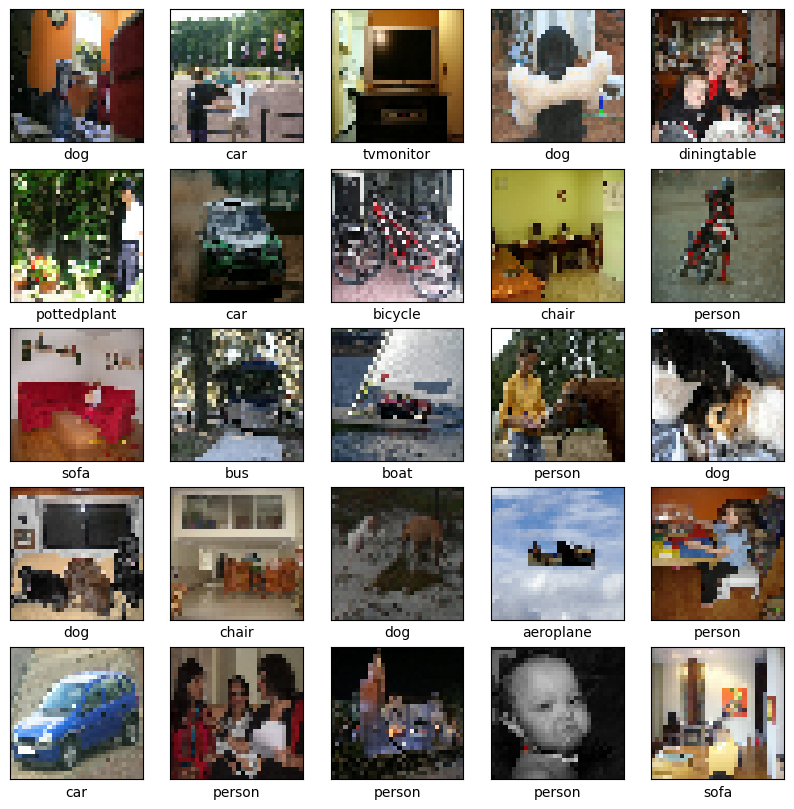

In [209]:
visualiza_imagens(imagem_teste, labels_teste)

In [210]:
mlb = MultiLabelBinarizer()
labels_treino_binary = mlb.fit_transform(labels_treino)
labels_teste_binary = mlb.transform(labels_teste)

In [211]:
mlb.classes_

array(['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car',
       'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
       'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'],
      dtype=object)

### Construção do Modelo

In [212]:
# Modelo

# Criar o objeto de sequência de camadas
modelo = models.Sequential()

# Adiciona o primeiro bloco de convolução e max pooling (camada de entrada)
modelo.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3))) # (32,32) é os pixel da imagem e o 3 é o rgb
modelo.add(layers.MaxPooling2D((2,2)))

# Adicionando o segundo bloco de convolução e max pooling (camada intermediária)
modelo.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
modelo.add(layers.MaxPooling2D((2,2)))

modelo.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
modelo.add(layers.MaxPooling2D((2,2)))

modelo.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
modelo.add(layers.MaxPooling2D((2,2)))




In [230]:
# Adicionar camadas de classificação
modelo.add(layers.Flatten())
modelo.add(layers.Dense(128, activation='relu'))
modelo.add(layers.Dense(20, activation='sigmoid'))



In [231]:
modelo.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 15, 15, 64)        18496     
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 3, 3, 128)        

In [270]:
modelo.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['binary_accuracy'])

In [271]:
%%time
history = modelo.fit(imagem_treino,
                    labels_treino_binary,
                    epochs=40,
                    validation_data=(imagem_teste, labels_teste_binary))

Epoch 1/40
55/55 [==============================] - 3s 35ms/step - loss: 0.2480 - binary_accuracy: 0.9203 - val_loss: 0.2395 - val_binary_accuracy: 0.9229
Epoch 2/40
55/55 [==============================] - 2s 30ms/step - loss: 0.2478 - binary_accuracy: 0.9203 - val_loss: 0.2394 - val_binary_accuracy: 0.9229
Epoch 3/40
55/55 [==============================] - 2s 30ms/step - loss: 0.2477 - binary_accuracy: 0.9203 - val_loss: 0.2392 - val_binary_accuracy: 0.9229
Epoch 4/40
55/55 [==============================] - 2s 29ms/step - loss: 0.2479 - binary_accuracy: 0.9203 - val_loss: 0.2392 - val_binary_accuracy: 0.9229
Epoch 5/40
55/55 [==============================] - 2s 28ms/step - loss: 0.2478 - binary_accuracy: 0.9203 - val_loss: 0.2393 - val_binary_accuracy: 0.9229
Epoch 6/40
55/55 [==============================] - 2s 29ms/step - loss: 0.2478 - binary_accuracy: 0.9203 - val_loss: 0.2393 - val_binary_accuracy: 0.9229
Epoch 7/40
55/55 [==============================] - 2s 28ms/step - los

### Avaliação do Modelo

In [123]:
def prever(predict):
    classe_prevista = np.argmax(predict)
    return nomes_classes[classe_prevista]

In [254]:
erro_teste, acc_teste = modelo.evaluate(imagem_teste, labels_teste_binary, verbose = 2)

109/109 - 0s - loss: 0.2393 - accuracy: 0.1347 - 460ms/epoch - 4ms/step


In [255]:
print('\nAcurácia com Dados de Teste:', acc_teste)


Acurácia com Dados de Teste: 0.13473744690418243


In [256]:
imagem_verifica = Image.open("/home/mateus/Downloads/nova_imagem.jpg")

In [257]:
imagem_verifica.size

(1919, 1199)

In [258]:
imagem_verifica = imagem_verifica.resize((32,32))

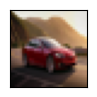

In [272]:
plt.figure(figsize = (1,1))
plt.imshow(imagem_verifica)
plt.xticks([])
plt.yticks([])
plt.show()

In [260]:
imagem_verifica.size

(32, 32)

In [273]:
imagem_verifica_np = np.array(imagem_verifica) / 255.0

In [274]:
imagem_verifica_np = np.expand_dims(imagem_verifica_np, axis=0)

In [275]:
predict = modelo.predict(imagem_verifica_np)

1/1 [==============================] - 0s 74ms/step


In [276]:
print(predict)

[[0.05203803 0.05022526 0.0694814  0.0334791  0.06134136 0.03514992
  0.1502514  0.06908362 0.11636665 0.02688148 0.05041655 0.08767746
  0.05732475 0.05260608 0.42704257 0.06552222 0.0237938  0.08632523
  0.04849344 0.06139309]]


In [277]:
print(prever(predict))

person


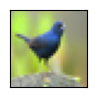

(32, 32)


In [204]:
imagem_verifica = Image.open("/home/mateus/Imagens/Tiziu.jpg")
imagem_verifica = imagem_verifica.resize((32,32))
plt.figure(figsize = (1,1))
plt.imshow(imagem_verifica)
plt.xticks([])
plt.yticks([])
plt.show()
print(imagem_verifica.size)
imagem_verifica_np = np.array(imagem_verifica) / 255.0
imagem_verifica_np = np.expand_dims(imagem_verifica_np, axis=0)

In [205]:
predict = modelo.predict(imagem_verifica_np)
print(predict)

1/1 [==============================] - 0s 16ms/step
[[3.7745618e-20 3.3720677e-19 1.1483192e-08 1.7802930e-19 3.5224543e-09
  2.6955695e-22 7.1993830e-14 1.9672961e-04 6.3902633e-16 5.5573008e-11
  7.8813058e-21 9.9977654e-01 2.0155538e-17 1.7338298e-15 4.2727954e-15
  2.1291453e-06 2.4567960e-05 1.7057216e-12 3.6592077e-15 1.1970865e-16]]


In [206]:
print(prever(predict))

dog
